In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

In [ ]:
# from google.colab import drive
# drive._mount('/content/drive')

In [ ]:
!unzip  "dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/1/9595607L.png  
  inflating: /content/dataset/test/0/9739300R.png  
  inflating: /content/dataset/train/1/9567019R.png  
  inflating: /content/dataset/train/1/9395178L.png  
  inflating: /content/dataset/test/0/9952817R.png  
  inflating: /content/dataset/test/0/9420682R.png  
  inflating: /content/dataset/test/0/9214480R.png  
  inflating: /content/dataset/train/1/9218916R.png  
  inflating: /content/dataset/train/1/9365269R.png  
  inflating: /content/dataset/test/0/9719890R.png  
  inflating: /content/dataset/test/0/9376146R.png  
  inflating: /content/dataset/test/0/9870268L.png  
  inflating: /content/dataset/test/0/9504627R.png  
  inflating: /content/dataset/train/1/9440005R.png  
  inflating: /content/dataset/test/0/9688844L.png  
  inflating: /content/dataset/test/0/9613159R.png  
  inflating: /content/dataset/train/1/9455270R.png  
  inflating: /content/dataset/test/0/9299531R.png  
  infl

In [ ]:
# Define the paths to the datasets



train_path = "/content/dataset/train"
val_path = "/content/dataset/val"
test_path = "/content/dataset/test"

# Define the classes
classes = ['0', '1', '2', '3', '4']

# Function to load images
def load_images(dataset_path):
    images = {}
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images[class_name] = [cv2.imread(os.path.join(class_path, img)) for img in os.listdir(class_path)]
    return images

# Load the images
train_images = load_images(train_path)
test_images = load_images(test_path)
val_images = load_images(val_path)

In [ ]:
# Function to get label distribution
def get_label_distribution(dataset_path):
    distribution = {}
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        distribution[class_name] = len(os.listdir(class_path))
    return distribution

# Get the label distribution for each dataset
train_distribution = get_label_distribution(train_path)
test_distribution = get_label_distribution(test_path)
val_distribution = get_label_distribution(val_path)

# Print the label distribution
print("Training Set:", train_distribution)
print("Testing Set:", test_distribution)
print("Validation Set:", val_distribution)

Training Set: {'0': 2286, '1': 1046, '2': 1516, '3': 757, '4': 173}
Testing Set: {'0': 639, '1': 296, '2': 447, '3': 223, '4': 51}
Validation Set: {'0': 328, '1': 153, '2': 212, '3': 106, '4': 27}


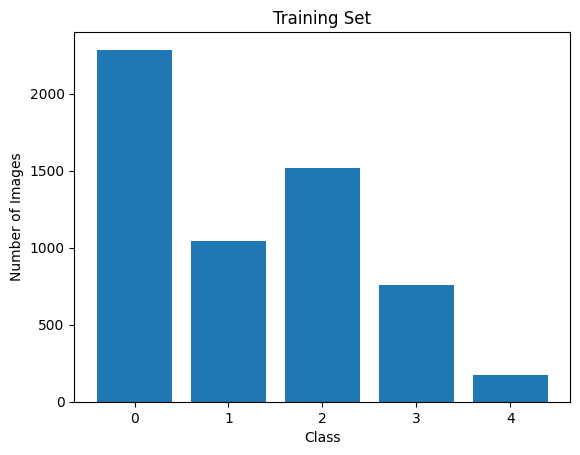

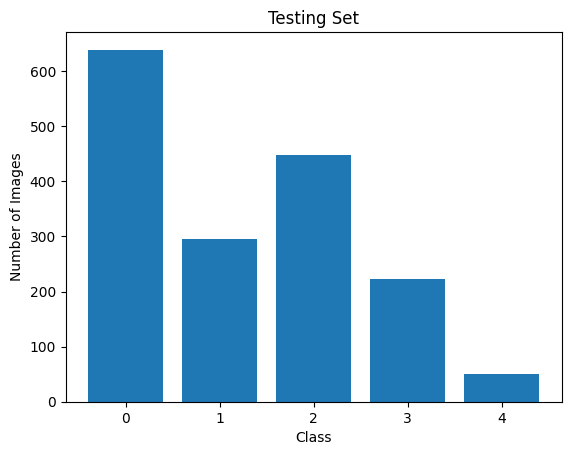

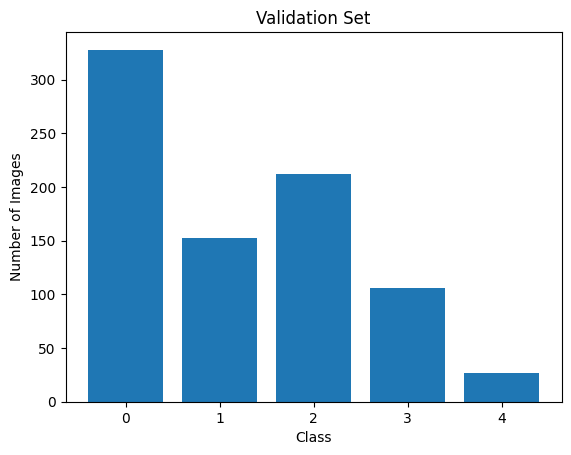

In [ ]:
import matplotlib.pyplot as plt

# Function to plot label distribution
def plot_label_distribution(distribution, title):
    plt.bar(distribution.keys(), distribution.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

# Plot the label distribution for each dataset
plot_label_distribution(train_distribution, 'Training Set')
plot_label_distribution(test_distribution, 'Testing Set')
plot_label_distribution(val_distribution, 'Validation Set')


In [ ]:
# Function to visualize images
def visualize_images(images, title):
    num_samples_per_class = 3
    plt.figure(figsize=(10, 10))
    for i, class_name in enumerate(classes):
        class_images = images[class_name][:num_samples_per_class]
        for j, img in enumerate(class_images):
            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
            plt.title(f"{title} - Class {class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

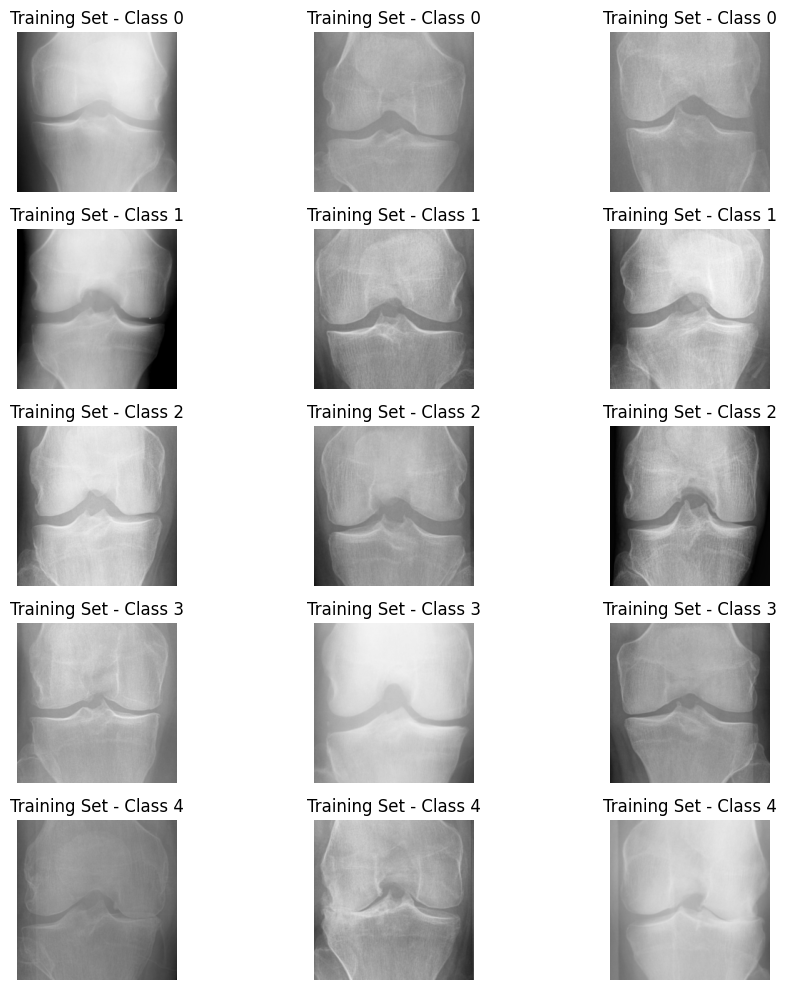

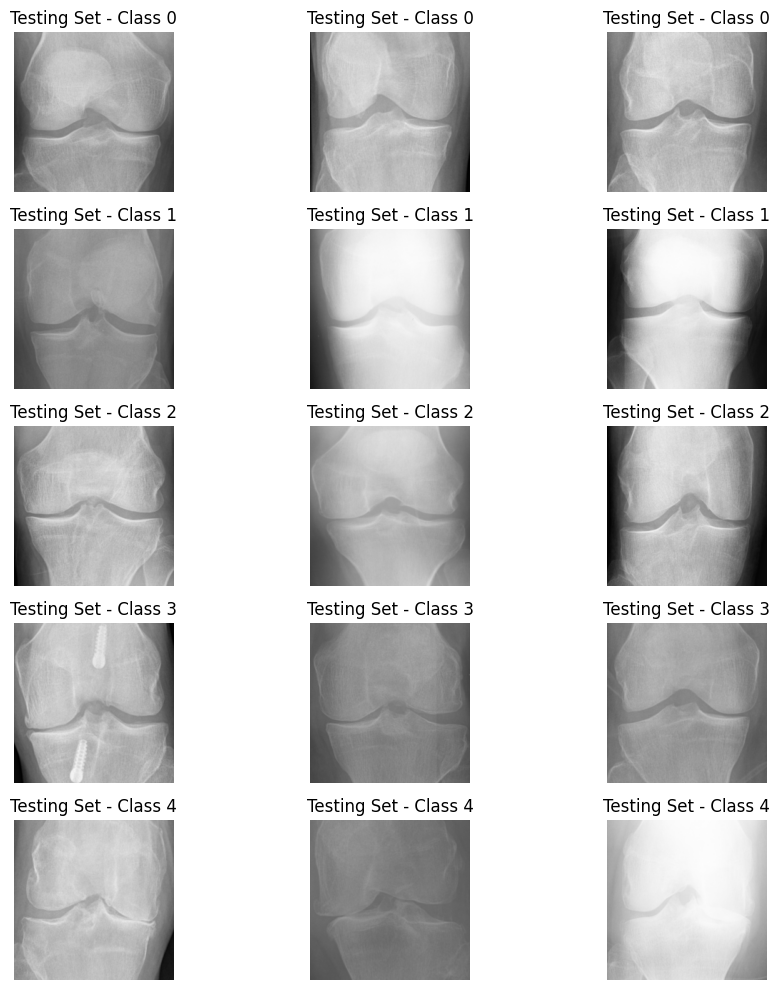

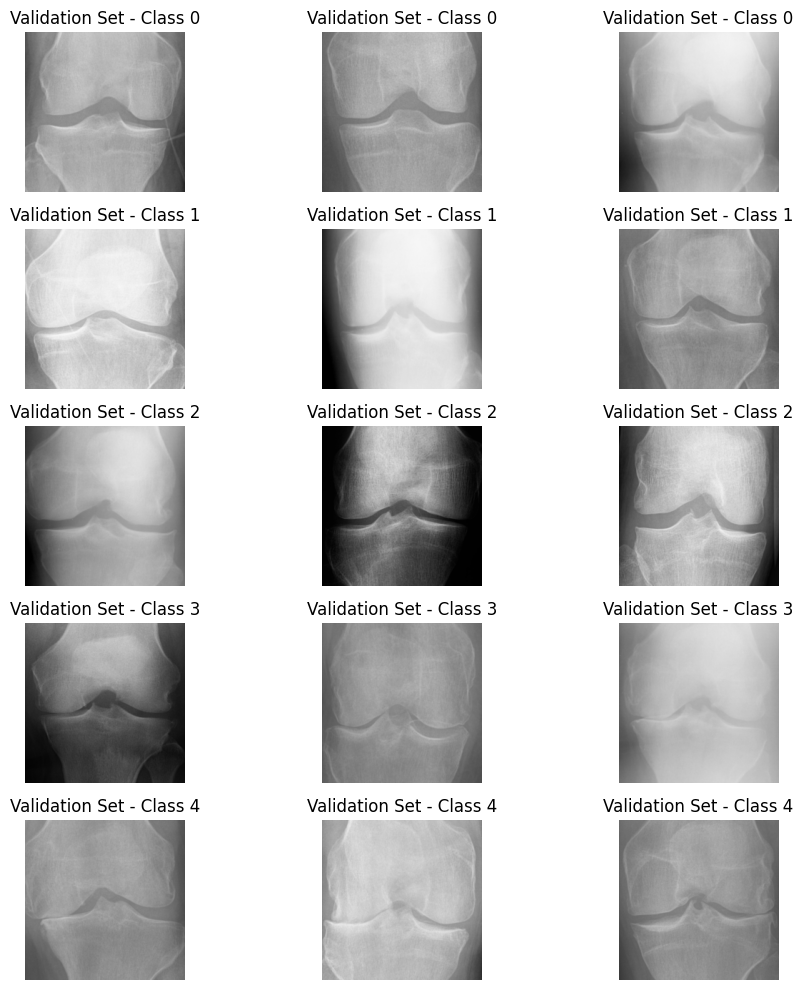

In [ ]:
# Visualize the images
visualize_images(train_images, 'Training Set')
visualize_images(test_images, 'Testing Set')
visualize_images(val_images, 'Validation Set')

In [ ]:
def load_preprocess_extract_images(path, classes, resize_dim=(98, 98), roi_coords=(13, 13, 78, 78)):
    images = []
    labels = []
    total_images = sum([len(os.listdir(os.path.join(path, class_name))) for class_name in classes])
    processed_images = 0

    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            # Load the image
            img = cv2.imread(os.path.join(class_path, img_name))

            # Resize the image
            img = cv2.resize(img, resize_dim)

            # Extract the ROI (Region of Interest)
            x, y, w, h = roi_coords
            img = img[y:y+h, x:x+w]

            # Convert the image to float32 and normalize it
            img = np.array(img, dtype='float32')
            img = img / 127.5 - 1

            # Add the image and label to the lists
            images.append(img)
            labels.append(i)

            # Update and print progress
            processed_images += 1
            progress = (processed_images / total_images) * 100
            print(f'Processing images: {progress:.2f}% completed', end='\r')

    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load, preprocess, and extract features from the images
X_train, Y_train = load_preprocess_extract_images(train_path, classes)
X_val, Y_val = load_preprocess_extract_images(val_path, classes)
X_test, Y_test = load_preprocess_extract_images(test_path, classes)

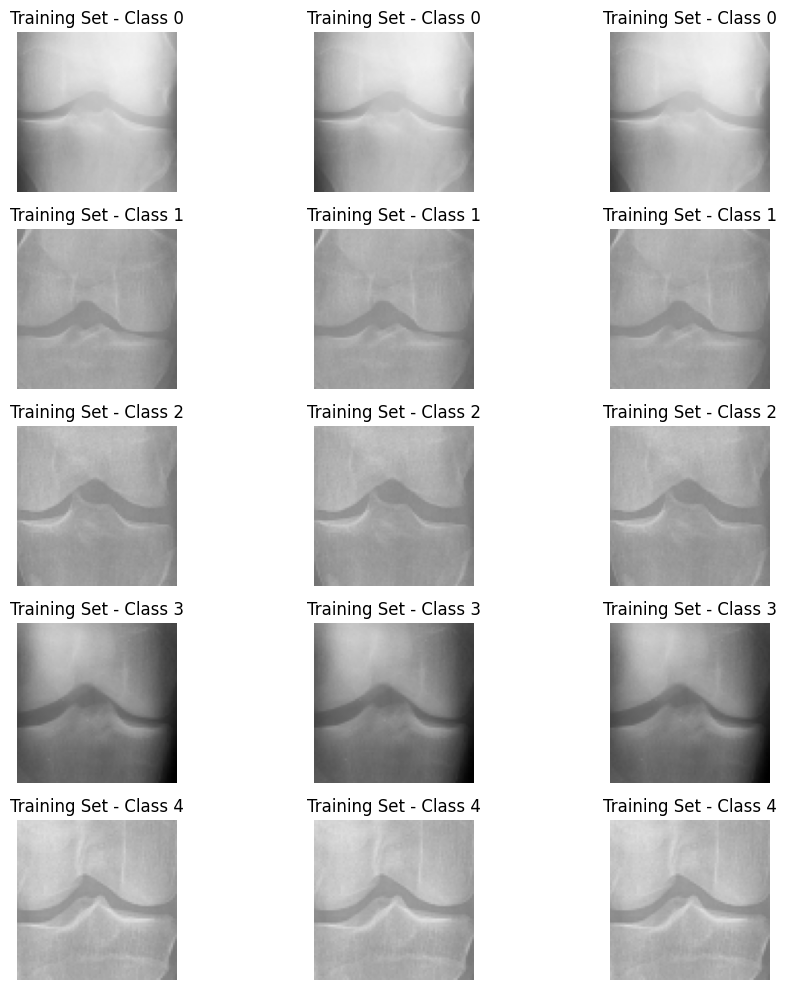

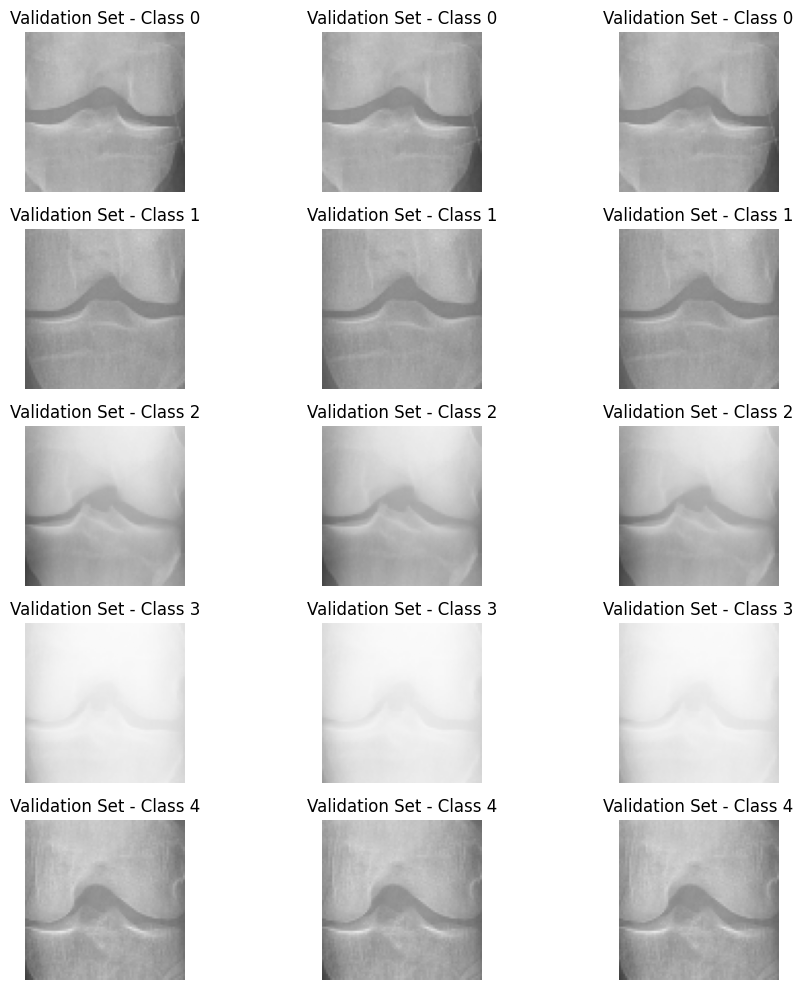

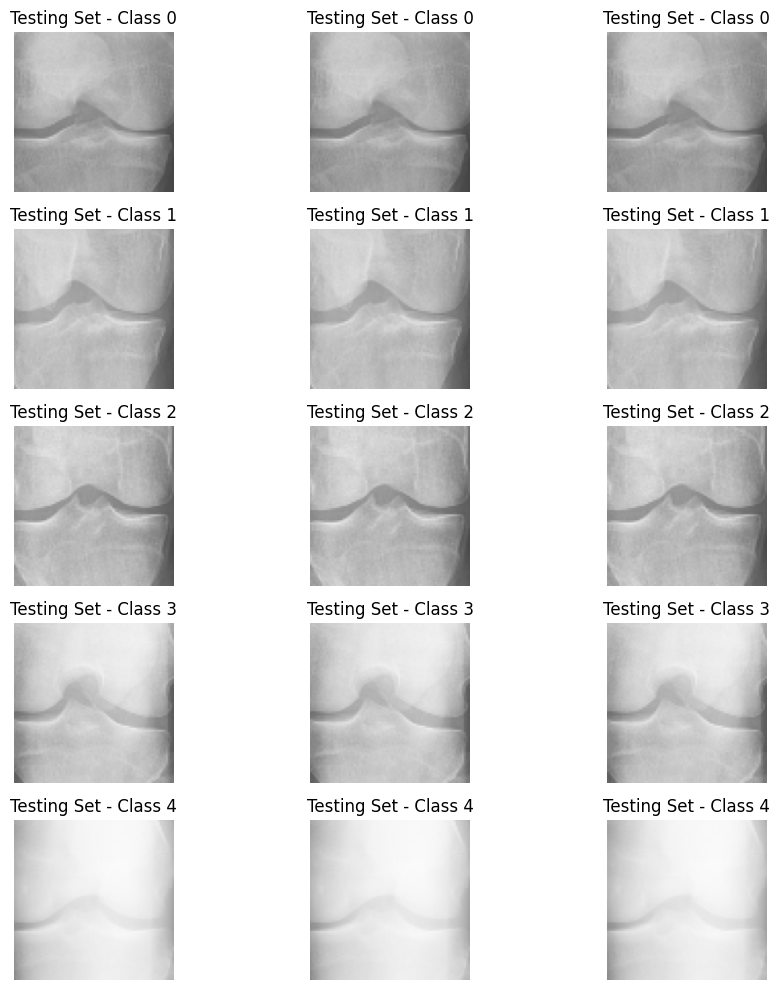

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize images
def visualize_images(images, labels, title):
    num_samples_per_class = 3
    plt.figure(figsize=(10, 10))
    for i, class_name in enumerate(classes):
        class_indices = np.where(labels == i)[0][:num_samples_per_class]
        for j, idx in enumerate(class_indices):
            img = (images[i] + 1) * 127.5 / 255  # Convert back to 0-1 range for display
            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(img, cmap='gray')  # Use grayscale colormap for binary images
            plt.title(f"{title} - Class {class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize the images
visualize_images(X_train, Y_train, 'Training Set')
visualize_images(X_val, Y_val, 'Validation Set')
visualize_images(X_test, Y_test, 'Testing Set')

In [ ]:
print("shape of train : ",X_train.shape)
print("shape of val : ",X_val.shape)
print("shape of test : ",X_test.shape)

shape of train :  (5778, 78, 78, 3)
shape of val :  (826, 78, 78, 3)
shape of test :  (1656, 78, 78, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Define paths for augmented datasets
aug_train_path = '/kaggle/working/augmented/train'
aug_val_path = '/kaggle/working/augmented/val'

# Function to create directories if they don't exist
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        for class_name in classes:
            os.makedirs(os.path.join(path, class_name))

# Create directories for augmented datasets
create_dir(aug_train_path)
create_dir(aug_val_path)

# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True
)

# Function to augment images
def augment_images(source_path, target_path, target_count):
    for class_name in classes:
        class_path = os.path.join(source_path, class_name)
        target_class_path = os.path.join(target_path, class_name)

        images = [cv2.imread(os.path.join(class_path, img)) for img in os.listdir(class_path)]
        images = np.array(images)

        # Data augmentation
        aug_gen = datagen.flow(images, batch_size=1, save_to_dir=target_class_path,
                               save_prefix='aug', save_format='jpeg')

        # Generate enough images to reach the target count
        current_count = len(os.listdir(target_class_path))
        while current_count < target_count:
            next(aug_gen)
            current_count += 1

# Calculate target count based on the majority class
majority_class_count = max(train_distribution.values())

# Augment the training and validation sets
augment_images(train_path, aug_train_path, majority_class_count)
augment_images(val_path, aug_val_path, majority_class_count)

# Load the augmented images
aug_train_images = load_images(aug_train_path)
aug_val_images = load_images(aug_val_path)

# Get the label distribution for the augmented datasets
aug_train_distribution = get_label_distribution(aug_train_path)
aug_val_distribution = get_label_distribution(aug_val_path)

# Print the label distribution for augmented datasets
print("Augmented Training Set:", aug_train_distribution)
print("Augmented Validation Set:", aug_val_distribution)

# Now you can use the augmented datasets for training
train_path_aug = aug_train_path
val_path_aug = aug_val_path

Augmented Training Set: {'0': 2286, '1': 2286, '2': 2286, '3': 2286, '4': 2284}
Augmented Validation Set: {'0': 2284, '1': 2285, '2': 2284, '3': 2285, '4': 2272}


In [ ]:
# Load, preprocess, and extract features from the images
X_train, Y_train = load_preprocess_extract_images(train_path_aug, classes)
X_val, Y_val = load_preprocess_extract_images(val_path_aug, classes)

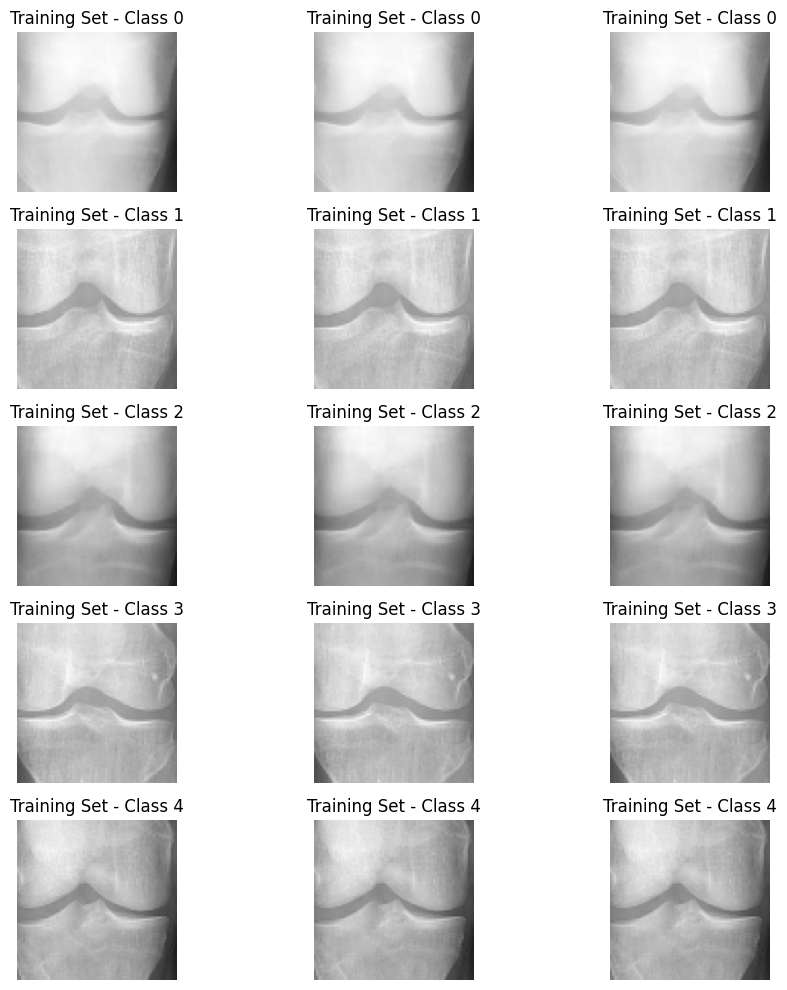

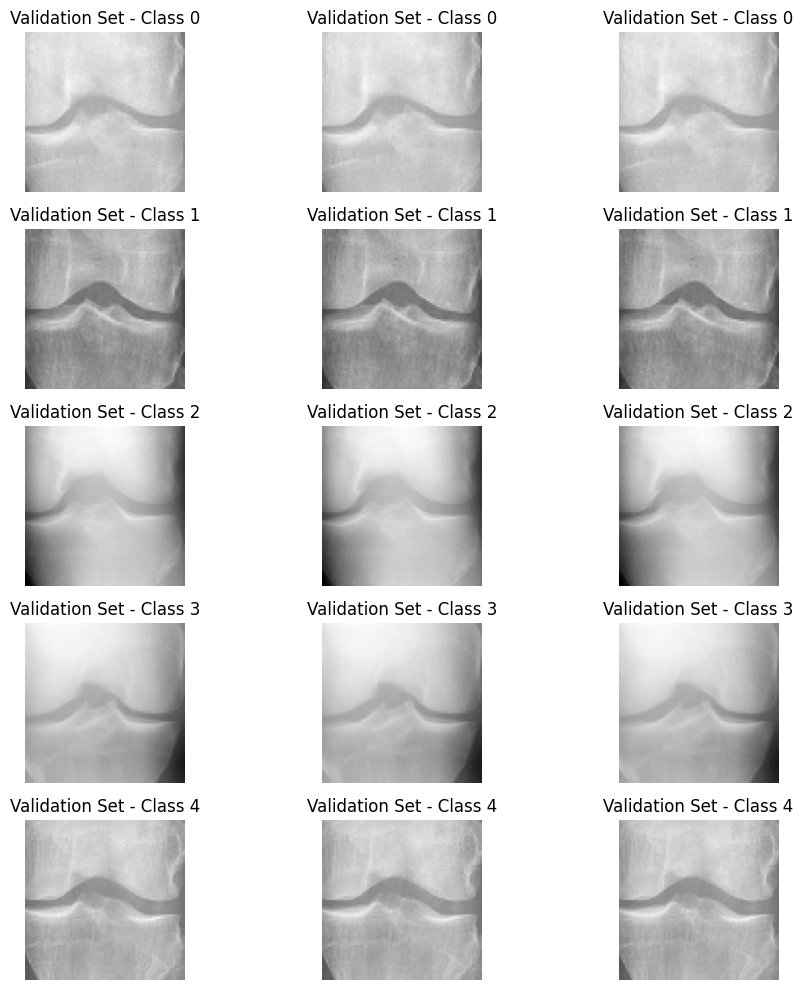

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize images
def visualize_images(images, labels, title):
    num_samples_per_class = 3
    plt.figure(figsize=(10, 10))
    for i, class_name in enumerate(classes):
        class_indices = np.where(labels == i)[0][:num_samples_per_class]
        for j, idx in enumerate(class_indices):
            img = (images[i] + 1) * 127.5 / 255  # Convert back to 0-1 range for display
            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(img, cmap='gray')  # Use grayscale colormap for binary images
            plt.title(f"{title} - Class {class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize the images
visualize_images(X_train, Y_train, 'Training Set')
visualize_images(X_val, Y_val, 'Validation Set')

In [ ]:
model = Sequential()

# Conv2d
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(78, 78, 3)))

# Maxpooling2d
model.add(MaxPooling2D(pool_size=(2, 2)))

# Batch Normalization
model.add(BatchNormalization())
#_____________________________________________________________________
# Conv2d_1
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))

# Maxpooling2d_1
model.add(MaxPooling2D(pool_size=(2, 2)))

# Batch Normalization_1
model.add(BatchNormalization())
#_____________________________________________________________________

# Conv2d_2
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

# Dropout_2
model.add(Dropout(0.25))  # Assuming a dropout rate of 0.25

# Maxpooling2d_2
model.add(MaxPooling2D(pool_size=(2, 2)))

# Batch Normalization_2
model.add(BatchNormalization())
#_____________________________________________________________________

# Conv2d_3
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))

# Dropout_1
model.add(Dropout(0.25))  # Assuming a dropout rate of 0.25

# Maxpooling2d_3
model.add(MaxPooling2D(pool_size=(2, 2)))

# Batch Normalization_3
model.add(BatchNormalization())
#_____________________________________________________________________

# Flatten
model.add(Flatten())

# Dense
model.add(Dense(units=8, activation='relu')) # Assuming 128 units

# Dropout_2
model.add(Dropout(0.5)) # Assuming a dropout rate of 0.5

# Dense_1
model.add(Dense(units=5, activation='softmax')) # Assuming 5 output classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 76, 76, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 38, 38, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 38, 38, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
from tensorflow.keras.regularizers import l2

# Define the model with L2 regularization
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(78, 78, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 76, 76, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 76, 76, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 38, 38, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 36, 36, 64)       

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import image_dataset_from_directory

# Compile the model with a specified initial learning rate
initial_learning_rate = 0.0001
# Compile the model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.03))  # Adjusted decay rate

# Callback for the learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3)

In [ ]:
# Fit the model
history = model.fit(X_train,Y_train, epochs=100, batch_size=32 ,validation_data=(X_val, Y_val),callbacks=[lr_scheduler])

Epoch 1/100
358/358 [==============================] - 274s 758ms/step - loss: 3.5806 - accuracy: 0.2421 - val_loss: 3.2973 - val_accuracy: 0.1978 - lr: 1.0000e-04
Epoch 2/100
358/358 [==============================] - ETA: 0s - loss: 3.2732 - accuracy: 0.2808

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict probabilities for test set
Y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
Y_pred = np.argmax(Y_pred_probs, axis=1)

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Define class labels

class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Generate classification report
class_report = classification_report(Y_test, Y_pred, target_names=classes)
print("Classification Report:")
print(class_report)

In [ ]:
# Define a function to plot actual vs predicted labels
def plot_actual_vs_predicted(actual, predicted, class_labels):
    plt.figure(figsize=(10, 6))
    for i in range(len(class_labels)):
        plt.subplot(2, 3, i+1)
        plt.hist([actual, predicted], bins=np.arange(len(class_labels) + 1) - 0.5, color=['blue', 'orange'], edgecolor='black', alpha=0.7, label=['Actual', 'Predicted'])
        plt.xticks(range(len(class_labels)), class_labels)
        plt.xlabel('Class')
        plt.ylabel('Frequency')
        plt.title(f'Class {i}')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Plot actual vs predicted labels
plot_actual_vs_predicted(Y_test, Y_pred, class_labels)

In [ ]:
import random

# Define a function to visualize images along with their actual and predicted labels
def visualize_actual_vs_predicted(images, actual_labels, predicted_labels, class_labels, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(images)-1)
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Actual: {class_labels[actual_labels[idx]]}')
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f'Predicted: {class_labels[predicted_labels[idx]]}')
        plt.axis('off')
    plt.show()

# Visualize actual vs predicted labels along with images
visualize_actual_vs_predicted(X_test, Y_test, Y_pred, class_labels)

In [ ]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model1 = Sequential([
        model,
        Flatten(),
        Dense(hp.Int('units', min_value=128, max_value=512, step=32), activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess and predict a single image
def predict_image(image_path, model, class_labels):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Resize the image to the required size (78, 78)
    img_resized = cv2.resize(img, (78, 78))

    # Extract the ROI (Region of Interest)
    x, y, w, h = 13, 13, 78, 78
    img_roi = img_resized[y:y+h, x:x+w]

    # Normalize the image
    img_normalized = np.array(img_roi, dtype='float32') / 127.5 - 1

    # Expand dimensions to match the input shape of the model (1, 78, 78, 3)
    img_expanded = np.expand_dims(img_normalized, axis=0)

    # Predict the class
    prediction = model.predict(img_expanded)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the image with the predicted class
    plt.imshow(img)
    plt.title(f"Predicted Class: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

# Example usage
image_path = "/dataset/test/0/9003175L.png"
predict_image(image_path, model, class_labels)
